## Climate Data Analysis
Climate data is from the world bank; read more about these time series [here](https://climateknowledgeportal.worldbank.org/country/uruguay/climate-data-historical).

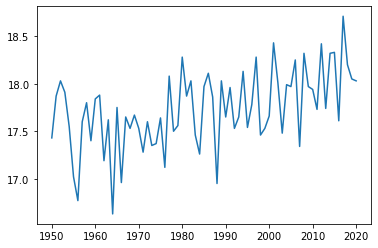

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/observed-average-annual-temperature-of-uruguay-for-1901-2020.csv')
climate_df = climate_df[climate_df.year >= 1950] # Need to adjust this to match length of ENSO records
year = climate_df.year.values.reshape(-1,1)
temp = climate_df.annual_mean.values.reshape(-1,1)
plt.plot(year, temp);

## Finding Seasonal Component 
We'll cover more structured ways to uncover a seasonal component later in the course. 
For now, let's just use trial and error, finding a well-fitting sinusoidal approximation. 

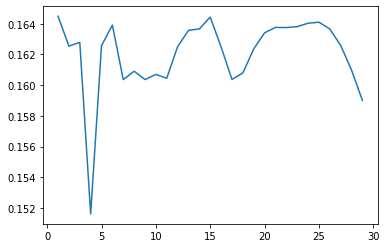

minimizing period is: 4


In [ ]:
from scipy import optimize
period_range = np.arange(1, 30)
mse_list = []

def find_sine_approximation(period ):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = year.flatten(),
    ydata = temp.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(year, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period)
  mse = np.nanmean((temp - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)

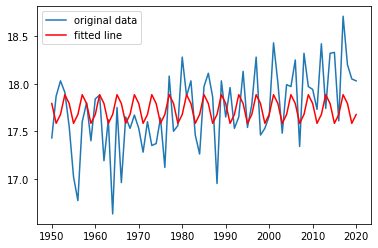

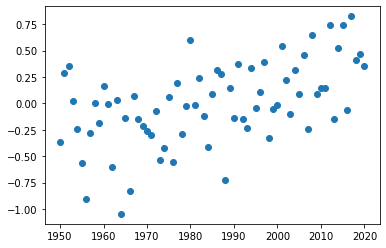

MSE with sinusoidal approximation 0.15160706493447512


In [ ]:
period = period_guess 
temp_sin_hat = find_sine_approximation(period)
plt.plot(year, temp, label='original data')
plt.plot(year, temp_sin_hat, 'r', label='fitted line')
plt.legend()
plt.show()
sin_residuals = temp - temp_sin_hat
plt.plot(year, sin_residuals, 'o')
plt.show();
print("MSE with sinusoidal approximation", np.mean((temp - temp_sin_hat)**2))

## Including ENSO index
ENSO index is from [here](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php); we use ONI, which is a measure of how anomalously warm or cool the central-to-eastern equatorial Pacific Ocean is compared to "normal".

I've aggregated this data to yearly values to standardize the comparison; this index is only available from 1950-2020 so we focus on that range while incorporating this regressor. 

In [ ]:
# No need to change this block; reads data from github
import pandas as pd
enso_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/enso_index.csv')
ONI = enso_df['ONI_index'].values.reshape(-1,1)
plt.plot(year, ONI)

[[0.21369093]]


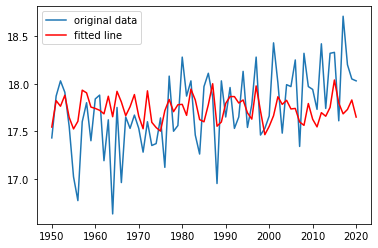

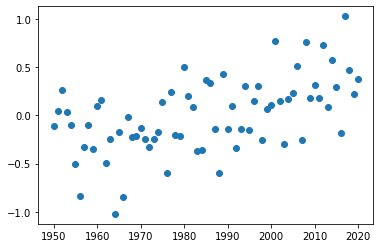

MSE with ENSO: 0.14748969990556732


In [ ]:
clf.fit(ONI, temp)
print(clf.coef_)
enso_predictions = clf.predict(ONI)
plt.plot(year, temp, label='original data')
plt.plot(year, enso_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
enso_residuals = temp - enso_predictions
plt.plot(year, enso_residuals, 'o')
plt.show()
print("MSE with ENSO:", np.mean((temp - enso_predictions)**2))

## Fit a trend line
As in the simulated exercise, start by fitting a line and plotting the residuals. 

Fit the line to the result from removing the ENSO pattern. 

[[0.01009514]]


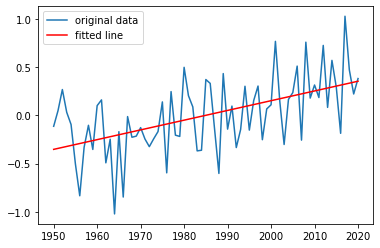

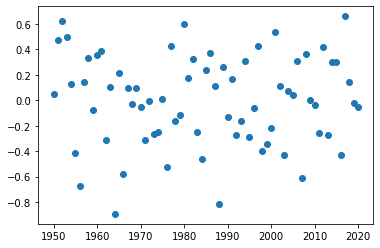

MSE with linear fit and accounting for ENSO: 0.12313917571154644


In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(year, enso_residuals)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(year)
plt.plot(year, enso_residuals, label='original data')
plt.plot(year, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = enso_residuals - linear_prediction
plt.plot(year, residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO:", np.mean((temp - temp_hat)**2))

[[0.01008305 0.22595482 1.02903227]]


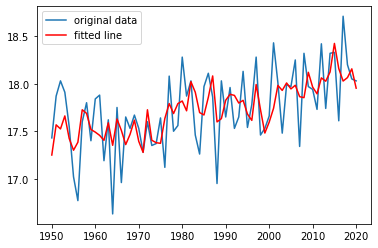

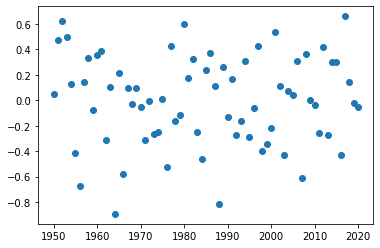

MSE with linear fit and accounting for ENSO and sinusoidal pattern: 0.09884959490049718


In [131]:
new_x = np.hstack((year, ONI, sin_prediction))
clf.fit(new_x, temp)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(new_x)
plt.plot(year, temp, label='original data')
plt.plot(year, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = temp - linear_prediction
plt.plot(year, residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO and sinusoidal pattern:", np.mean((linear_residuals)**2))


## Conclusions about Climate Change:
After accounting for internal variability (ENSO or other seasonal components), what is your best guess of the degree of warming since 1950? 

In [137]:
# To estimate, I use our augmented linear model (this had the best prediction score)
# I multiply the parameter estimate for "year" by the number of years passed. 
estimated_warming = clf.coef_[0][0] * (2020 - 1950)
print(estimated_warming)

0.7058132968301825


MSE from seasona decomposition 0.0855035235532976


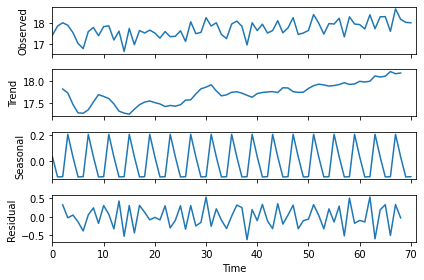

In [134]:
# Again, we can consider comparing to the statsmodels package. 
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(temp, freq=4)
res.plot()
print("MSE from seasona decomposition", np.nanmean(res.resid **2))
plt.show()